# Intro

This notebook aims to create machine learning models that accurately classify the sentiment of tweets related to different products, and is intended for data scientists and business professionals interested in analyzing customer feedback on social media to gain insights into customer sentiment.

The notebook is organized into several sections covering data collection, preprocessing, exploratory data analysis, feature extraction, machine learning models, model evaluation, and business implications.

The business problem that this notebook addresses is helping companies understand the sentiment of their customers towards their products or services by analyzing social media data. By analyzing customer feedback on platforms such as Twitter, companies can gain insights into customer opinions, identify areas for improvement, and make data-driven decisions to enhance customer satisfaction and loyalty.

In [1]:
# Import necessary libraries for the project
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Set random seeds to ensure reproducibility of results
np.random.seed(42)
tf.random.set_seed(42)

# Sets verbose arguments of all models to that output is hidden in final notebook
global_verbose = 1 

plt.style.use("ggplot")

2023-03-24 10:36:56.966919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

Here, df2 is a signifficantly larger dataset that we will extract some relevant information from to hopefully bolster performance.

In [2]:
# Load the product_tweet_prediction dataset as a Pandas dataframe
df = pd.read_csv("Data/product_tweet_prediction.csv", encoding="ISO-8859-1")

# Load the train dataset as a Pandas dataframe, drop any rows with missing values
df2 = pd.read_csv("Data/train.csv").dropna()


The other dataset is much larger and more broad, so I will try to filter for tweets which are associated with products.

In [3]:
# Define a regular expression pattern to match product and service names
prod_servs = r"sxwsw|iphone|ipad|apple|google|android|ipod|service|xbox|twitter|playstation|spotify|itunes|amazon|starbucks|walmart|target|samsung|adidas|under armour|facebook|fox news|cnn|nintendo|youtube|you tube"

# Use regular expression matching to determine whether a tweet contains a product or service name
prods = df2.text.str.contains(r"(?:" + prod_servs + r")\b", flags=re.IGNORECASE)

# Filter the tweets that contain product or service names and select the "text" and "sentiment" columns
extra = df2[prods][["text", "sentiment"]].reset_index(drop=True)

# Rename the "text" column to "tweet_text" for clarity
extra.rename(columns={"text":"tweet_text"}, inplace=True)

# Map the "sentiment" column values to 0, 1, or 2 based on negative, positive, or neutral sentiment respectively
extra.sentiment = extra.sentiment.map({"negative":0, "positive":1, "neutral":2})

# Store the resulting dataframe in the "extra" variable
extra

,tweet_text,sentiment
0,"the free fillin` app on my ipod is fun, im add...",1
1,I`m going home now. Have you seen my new twitt...,1
2,:visiting my friendster and facebook,2
3,Then you should check out http://twittersucks...,2
4,mannnn..... _ got an iphone!!! im jealous.... ...,0
...,...,...
1051,that`s cuz you`re cruising the twitter #night...,2
1052,Twitter is slow!,0
1053,This is a much better tool than some I have co...,1
1054,my cousins moved there like 2 years ago and ...,0


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# Rename the "is_there_an_emotion_directed_at_a_brand_or_product" column to "sentiment" for clarity
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "sentiment"}, inplace=True)

In [6]:
# Drop all rows where the sentiment column contains the value "I can't tell"
df = df[df['sentiment'] != "I can't tell"]

# Factorize the "sentiment" column to convert categorical values to numerical values
df.sentiment = df.sentiment.factorize()[0]

# Select only the "tweet_text" and "sentiment" columns from the dataframe
df = df[["tweet_text", "sentiment"]]

# Store the resulting dataframe in the "df" variable
df

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1
...,...,...
9088,Ipad everywhere. #SXSW {link},1
9089,"Wave, buzz... RT @mention We interrupt your re...",2
9090,"Google's Zeiger, a physician never reported po...",2
9091,Some Verizon iPhone customers complained their...,2


In [7]:
# Concatenate the "df" and "extra" dataframes vertically using pd.concat()
df = pd.concat([df, extra], axis=0)

# Count the number of tweets in each sentiment category and calculate their proportions using the normalize parameter
df.sentiment.value_counts(True)

2    0.587111
1    0.330932
0    0.081957
Name: sentiment, dtype: float64

There is a massive class imbalance that will prove challenging when training models. I will

In [8]:
neuts = df[df.sentiment == 2]

neuts = neuts.iloc[: int(len(neuts) / 2)]
df = df.drop(neuts.index).reset_index()
df.sentiment.value_counts(True)

1    0.481487
2    0.414407
0    0.104105
Name: sentiment, dtype: float64

## Text Preproccessing

In [9]:
# Import necessary libraries for text preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# Define a list of regular expression patterns to replace with empty string
re_subs = [
    (r"\d+", ""), # remove digits
    (r"\b\w\b", ""), # remove single letter words
    (r"[^\w\s]", ""), # remove punctuation
    (r"https?://\S+|www\.\S+", ""), # remove urls
    # (prod_servs, "product"), 
    (r"sxsw|mention", ""), # remove words with very high frequencies in all classes
    (r"\b(" + "|".join(stopwords.words("english")) + r")\b\s*", "") # remove stopwords
    ]

lemr = WordNetLemmatizer()

# Define a function to preprocess a given input string
def preprocess_text(input_string):
    # Convert input string to lowercase
    input_string = str(input_string).lower()
    
    # Replace regular expression patterns in input string with empty string
    for pattern, repl in re_subs:
        input_string = re.sub(pattern, repl, input_string)
    
    # Tokenize the input string into words
    tokens = word_tokenize(input_string)
    
    # Lemmatize each word in the input string, including verbs
    words = [lemr.lemmatize(word, pos="v") for word in tokens]
    
    # Join the words back together into a single string and return it
    return " ".join(words)


In [10]:
df.tweet_text = df.tweet_text.apply(preprocess_text) # Apply the preprocessing function defined above
df

,index,tweet_text,sentiment
0,0,wesley iphone hrs tweet rise_austin dead need ...,0
1,1,jessedee know fludapp awesome ipadiphone app y...,1
2,2,swonderlin wait ipad also sale,1
3,3,hope year festival crashy year iphone app,0
4,4,sxtxstate great stuff fri marissa mayer google...,1
...,...,...,...
6450,1050,someone horse btw hubb feel twitter name party,2
6451,1051,cuz youre cruise twitter nightshift,2
6452,1052,twitter slow,0
6453,1054,cousins move like years ago miss much look fac...,0


## Data Visualizations

In [11]:
# Show process of preparing raw tweets for model
from keras.preprocessing.text import Tokenizer

# Raw tweet example
tweet = "we love using my new wepad! Best #christmas gift ever!"

# Apply preprocessing steps
processed_tweet = preprocess_text(tweet) 

# Tokenize and vectorize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df.tweet_text)
sequenced_tweet = tokenizer.texts_to_sequences([processed_tweet])

# Print the steps
print(tweet)
print(processed_tweet)
print(sequenced_tweet)


we love using my new wepad! Best #christmas gift ever!
love use new wepad best christmas gift ever
[[49, 31, 8, 71, 1090, 693, 119]]


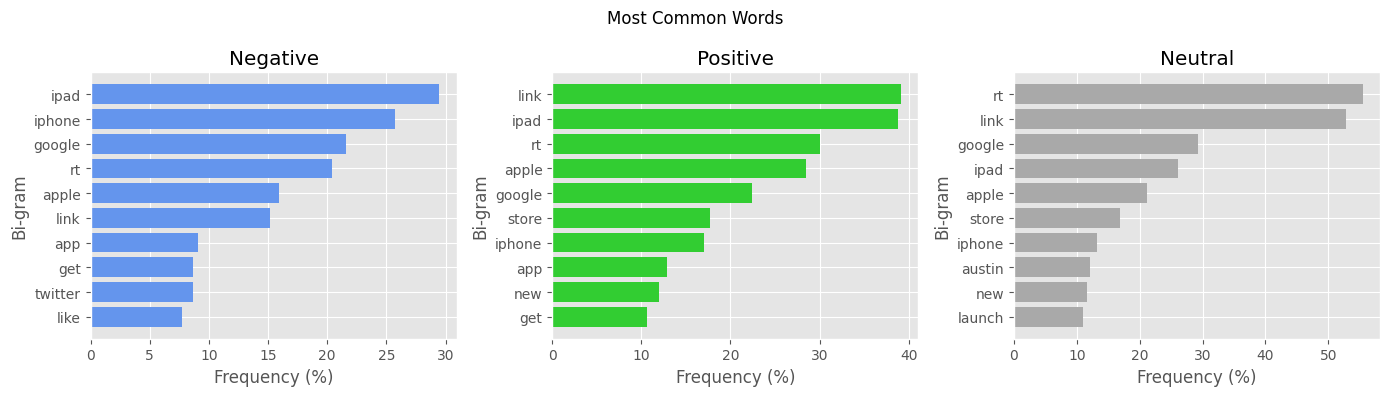

In [12]:
# Create the figure and three axes for each class
fig, axes = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)
fig.suptitle("Most Common Words")

# Create arrays of sentiment names and colors to represent them
senitments = ["Negative", "Positive", "Neutral"]
colors = ["cornflowerblue", "limegreen", "darkgrey"]

# Loop over the sentiment categories 0, 1, and 2
for sentiment in range(3):
    # Select the tweet_text for the current sentiment category
    texts = df.tweet_text[df.sentiment == sentiment]

    # Split the text into words and count the frequency of each word
    word_frequency = texts.str.split(expand=True).stack().value_counts().reset_index().head(10)
    
    # Rename the columns of the word_frequency dataframe
    word_frequency.columns = ["Word", "Frequency"] 

    # Normalize the word frequency
    word_frequency.Frequency /= len(texts) / 100

    # Create bar plot
    ax = axes[sentiment]
    
    ax.barh(word_frequency["Word"], word_frequency["Frequency"], color=colors[sentiment])
    ax.set_ylabel('Bi-gram')
    ax.set_xlabel('Frequency (%)')
    ax.set_title(senitments[sentiment])
    ax.invert_yaxis()

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(data, n, top_n):
    # Create a count vectorizer object
    vectorizer = CountVectorizer(ngram_range=(n,n))

    # Fit and transform the data
    X = vectorizer.fit_transform(data)

    # Get the feature names (n-grams)
    feature_names = vectorizer.get_feature_names_out()

    # Get the frequency count of each n-gram
    count_values = X.toarray().sum(axis=0)

    # Create a dictionary with the n-grams and their frequency counts
    ngram_freq = pd.DataFrame(zip(feature_names, count_values), columns=[f"{n}-gram", "frequency"])
    
    return ngram_freq.sort_values(by="frequency", ascending=False).head(top_n)

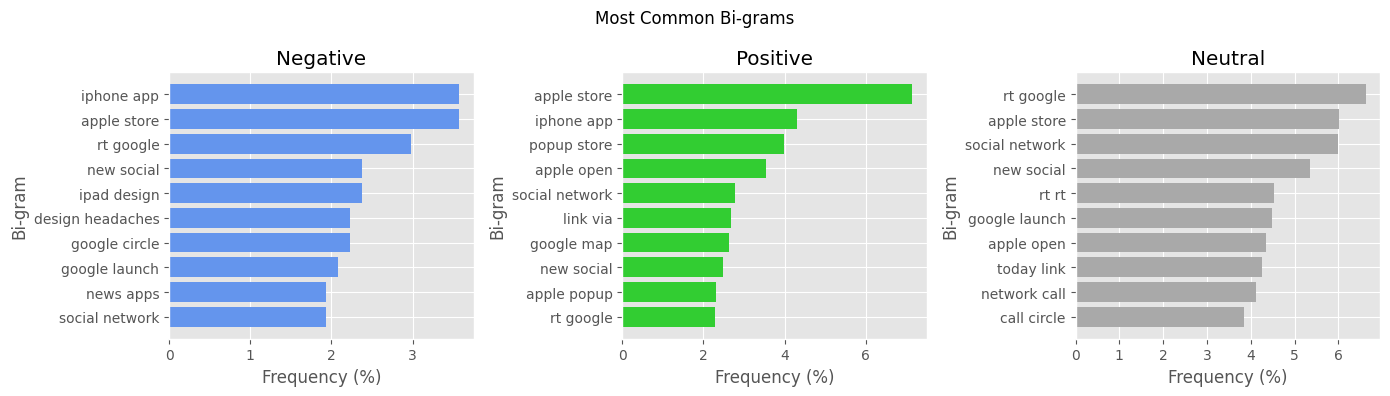

In [14]:
# Create a figure with three subplots, with a title.
fig, axes = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)
fig.suptitle("Most Common Bi-grams")

# Loop through the three different sentiments.
for sentiment in range(3):
    # Select the tweet texts with the current sentiment.
    sentences = df.tweet_text[df.sentiment == sentiment]
    
    # Get the top 10 bi-grams and their frequencies, and normalize the frequencies to a scale of 0 to 100.
    freqs = get_top_ngrams(sentences, 2, 10)
    freqs.frequency /= len(sentences) / 100

    # Select the corresponding subplot and create a horizontal bar chart of the bi-grams and their frequencies.
    ax = axes[sentiment]
    ax.barh(freqs["2-gram"], freqs["frequency"], color=colors[sentiment])

    # Set the y-label, x-label, and title for the current subplot.
    ax.set_ylabel('Bi-gram')
    ax.set_xlabel('Frequency (%)')
    ax.set_title(senitments[sentiment])
    ax.invert_yaxis()


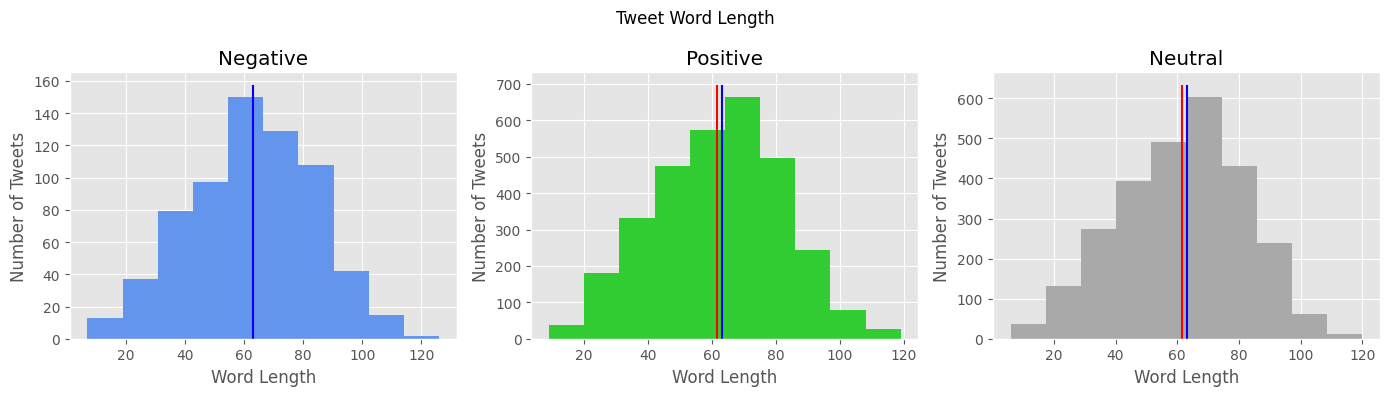

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)
fig.suptitle("Tweet Word Length")

# Add a new column to the dataframe "df" that contains the length of each tweet
df['length'] = df['tweet_text'].apply(len)

# Create a histogram of tweet lengths, grouped by sentiment, with a specified figure size

for sentiment in range(3):
    lengths = df.length[df.sentiment == sentiment]

    ax = axes[sentiment]

    ax.hist(lengths, color=colors[sentiment])
    ax.set_ylabel('Number of Tweets')
    ax.set_xlabel('Word Length')
    ax.vlines([lengths.mean(), lengths.median()], 0, ax.get_ylim()[1], colors=["red", "blue"])
    ax.set_title(senitments[sentiment])

# Binary Models

In [16]:
# Import the `train_test_split` function from the scikit-learn library.
from sklearn.model_selection import train_test_split

# Filter the DataFrame to only include positive and negative sentiments (binary classification).
binary_df = df[df.sentiment < 2]

# Split the filtered DataFrame into feature (X) and target (y) variables.
X = binary_df.tweet_text
y = binary_df.sentiment

# Split the feature and target variables into training, validation, and test sets, with a 80-10-10 split ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


#### Metric evaluation function

In [17]:
# Import necessary libraries for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Define a function to print classification metrics and confusion matrix
def metrics(y_true, y_pred):
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))
    
    # Display the classification report, which includes precision, recall, f1-score, and support
    metrics = classification_report(y_true, y_pred)
    ax=axes[1]
    ax.axis("off")
    ax.text(0.5, 0.25, metrics, size=12, ha="center", transform=ax.transAxes)

    ax = axes[0]
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Create confusion matrix plot, which shows the counts of true positives, false positives, true negatives, and false negatives
    sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    fig.tight_layout()

### Logistic Regression

In [18]:
# Import necessary libraries for building a machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define a pipeline for the machine learning model using TfidfVectorizer and LogisticRegression
pipe = Pipeline([
    ("vec", TfidfVectorizer(max_features=500000, ngram_range=(1,5))),
    ("clf", LogisticRegression(class_weight="balanced", random_state=42))
])

# Define a grid of hyperparameters to search over using GridSearchCV
param_grid = {
    "vec__ngram_range" : [(1,2), (1,3), (1,4)],
    "clf__C" : [1, 5, 10, 15],
    "clf__class_weight" : ["balanced", None]
}

# Perform a grid search over the hyperparameter grid using GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring="f1_macro")
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
grid_search.best_params_


{'clf__C': 5, 'clf__class_weight': 'balanced', 'vec__ngram_range': (1, 2)}

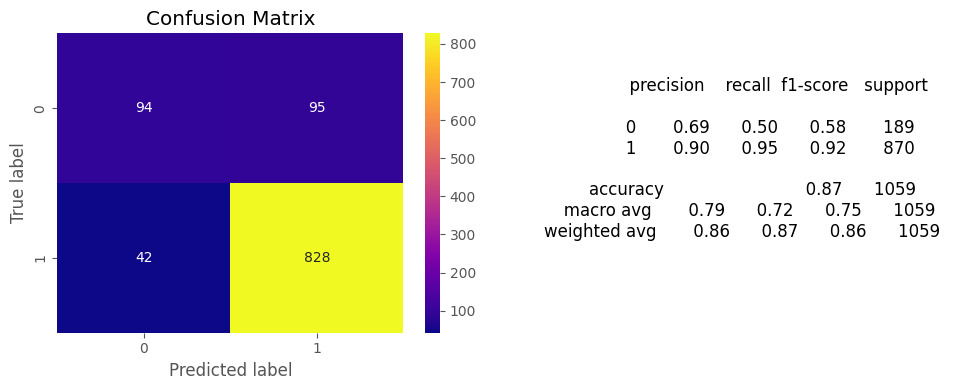

In [19]:
best_params = {'clf__C': 10, 'clf__class_weight': 'balanced', 'vec__ngram_range': (1, 2)}

# Set the best hyperparameters found by GridSearchCV on the pipeline
pipe.set_params(**best_params)

# Fit the pipeline on the training data
pipe.fit(X_train, y_train)

# Print the classification metrics and confusion matrix for the validation and test sets
metrics(pd.concat((y_val, y_test), axis=0), pipe.predict(pd.concat((X_val, X_test), axis=0)))

### SVM - SVC

In [20]:
# Import necessary libraries for building a support vector machine model
from sklearn.svm import SVC

# Define a pipeline for the support vector machine model using TfidfVectorizer and SVC
pipe_svm_2 = Pipeline([
    ("vec", TfidfVectorizer(max_features=int(5e6))),
    ("clf", SVC(kernel="linear", random_state=42))
])

# Define a grid of hyperparameters to search over using GridSearchCV
param_grid = {
    "vec__ngram_range" : [(1,2), (1,3)],
    "clf__kernel" : ["linear", "rbf"],
    "clf__gamma" : ["scale", "auto"],
    "clf__class_weight" : ["balanced", None]
}

# Perform a grid search over the hyperparameter grid using GridSearchCV
gsearch = GridSearchCV(pipe_svm_2, param_grid, cv=5, n_jobs=-1, scoring="f1_macro")
gsearch.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
gsearch.best_params_


{'clf__class_weight': 'balanced',
 'clf__gamma': 'scale',
 'clf__kernel': 'linear',
 'vec__ngram_range': (1, 2)}

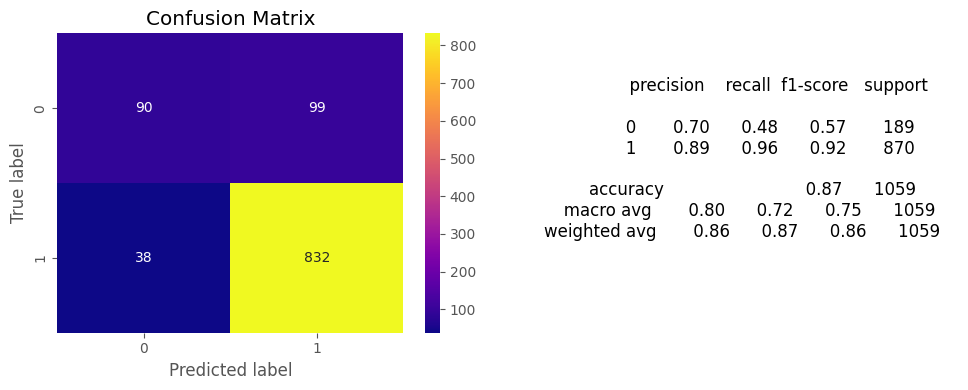

In [21]:
best_params = {'clf__class_weight': 'balanced',
 'clf__gamma': 'scale',
 'clf__kernel': 'linear',
 'vec__ngram_range': (1, 2)}

# Set best params and evaluate performance as with LR
pipe_svm_2.set_params(**best_params)
pipe_svm_2.fit(X_train, y_train)

metrics(pd.concat((y_val, y_test)), pipe_svm_2.predict(pd.concat((X_val, X_test), axis=0)))

## Neural Networks

A weighted class distribution is created in order to combat the massive class imbalance.  Otherwise, the models will likely try to simply predict the majority class.

In [22]:
# Import necessary libraries for computing class weights
from sklearn.utils import compute_class_weight

# Compute class weights for the training data
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

# Create a dictionary mapping class indices to class weights
class_weight_dict = dict(enumerate(class_weights))

# Print the resulting class weight dictionary
class_weight_dict

{0: 2.8125, 1: 0.6081081081081081}

### Preparing texts for Keras

Creating a Tokenizer object and fitting it on the training data (X_train) using the fit_on_texts() method will generate a word index that can be used to convert text to sequences of token weDs.

Converting to sequences of token weDs using the texts_to_sequences() method converts each word in the text to its corresponding token weD using the word index generated during training.

Padding the sequences with zeros will ensure they all have the same length (maxlen) using the pad_sequences() function. This is necessary because the model expects inputs of a fixed length, and so sequences that are shorter than maxlen are padded with zeros at the end, while sequences that are longer than maxlen are truncated.

In [23]:
# Import necessary libraries for text preprocessing
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum length of the input sequences and the number of words to keep
maxlen = 130
num_words = 10000

# Create a tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Convert the training, validation, and test data to sequences of token IDs using the tokenizer
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences with zeros to ensure they all have the same length
train_data = pad_sequences(train_sequences, maxlen=maxlen)
val_data = pad_sequences(val_sequences, maxlen=maxlen)
test_data = pad_sequences(test_sequences, maxlen=maxlen)

### NN Evaluation Function

In [24]:
def analyze_model(_history, _model, _test_data=test_data, y_true=y_test):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))

    # Generate predictions on the test data
    y_pred = _model.predict(_test_data)

    if y_pred.shape[1] == 1:
        y_pred = list((y_pred > 0.5).astype(int))
    else:
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)

    # Print model metrics report
    metrics = classification_report(y_true, y_pred)
    ax=axes[1][1]
    ax.axis("off")
    ax.text(0.5, 0.25, metrics, size=12, ha="center", transform=ax.transAxes)

    # Generate a confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    ax=axes[1][0]
    sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    # Plot the training and validation accuracy
    ax = axes[0][0]

    ax.plot(_history.history["accuracy"])
    ax.plot(_history.history["val_accuracy"])
    ax.set_title("Model Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend(["Train", "Val"])

    # Plot the training and validation loss
    ax = axes[0][1]
    ax.plot(_history.history["loss"])
    ax.plot(_history.history["val_loss"])
    ax.set_title("Model Loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend(["Train", "Val"])

    fig.tight_layout()


### Base Model

My base NN model will have a classic architecture of an embedding layer to capture semantic and syntactic relationships between words, followed by an LSTM layer to remember information from previous time steps.  The embedding layer takes the input words and maps them to dense vectors of fixed size, while the LSTM layer processes the sequences of words and extracts meaningful features from them.

In [25]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM

# Create a Sequential model
model = Sequential()

# Add an Embedding layer that maps input sequences of token weDs to dense vectors of fixed size
model.add(Embedding(input_dim=num_words, output_dim=128))

# Add an LSTM layer with 64 units to process the sequences of embedded vectors
model.add(LSTM(64))

# Add a Dense output layer with a single unit and a sigmoid activation function to generate binary predictions
model.add(Dense(1, "sigmoid"))

# Compile the model using the Adam optimizer, binary cross-entropy loss, and track accuracy and precision as metrics
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "Precision"])

# Fit the model on the training data and validate on the validation data for 20 epochs with a batch size of 16
# Use EarlyStopping to prevent overfitting and ModelCheckpoint to save the best weights of the model at each epoch
history = model.fit(
    train_data, 
    y_train, 
    verbose=global_verbose,
    validation_data=(val_data, y_val), 
    epochs=20, 
    batch_size=16, 
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath="model_checkpoints/base_" + "weights.{epoch:02d}.h5", save_weights_only=True)
    ],
)

2023-03-24 10:37:28.742633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
171/171 [==============================] - 8s 35ms/step - loss: 0.4292 - accuracy: 0.8258 - precision: 0.8286 - val_loss: 0.3580 - val_accuracy: 0.8517 - val_precision: 0.8521
Epoch 2/20
171/171 [==============================] - 5s 31ms/step - loss: 0.2126 - accuracy: 0.9162 - precision: 0.9266 - val_loss: 0.3652 - val_accuracy: 0.8605 - val_precision: 0.8836
Epoch 3/20
171/171 [==============================] - 5s 32ms/step - loss: 0.0907 - accuracy: 0.9673 - precision: 0.9773 - val_loss: 0.4846 - val_accuracy: 0.8399 - val_precision: 0.8982
Epoch 4/20
171/171 [==============================] - 5s 32ms/step - loss: 0.0495 - accuracy: 0.9849 - precision: 0.9911 - val_loss: 0.4990 - val_accuracy: 0.8546 - val_precision: 0.8932
Epoch 5/20
171/171 [==============================] - 5s 32ms/step - loss: 0.0286 - accuracy: 0.9915 - precision: 0.9942 - val_loss: 0.5699 - val_accuracy: 0.8576 - val_precision: 0.8883
Epoch 6/20
171/171 [==============================] - 5s 32ms/ste

The model's training performance improves with each epoch until epoch 5, where the validation loss increases while the accuracy and precision metrics do not improve. This suggests that the model may have started to overfit the training data.

Next steps include adjusting the model's hyperparameters and changing the architecture of the model to prevent overfitting.

12/12 [==============================] - 1s 11ms/step


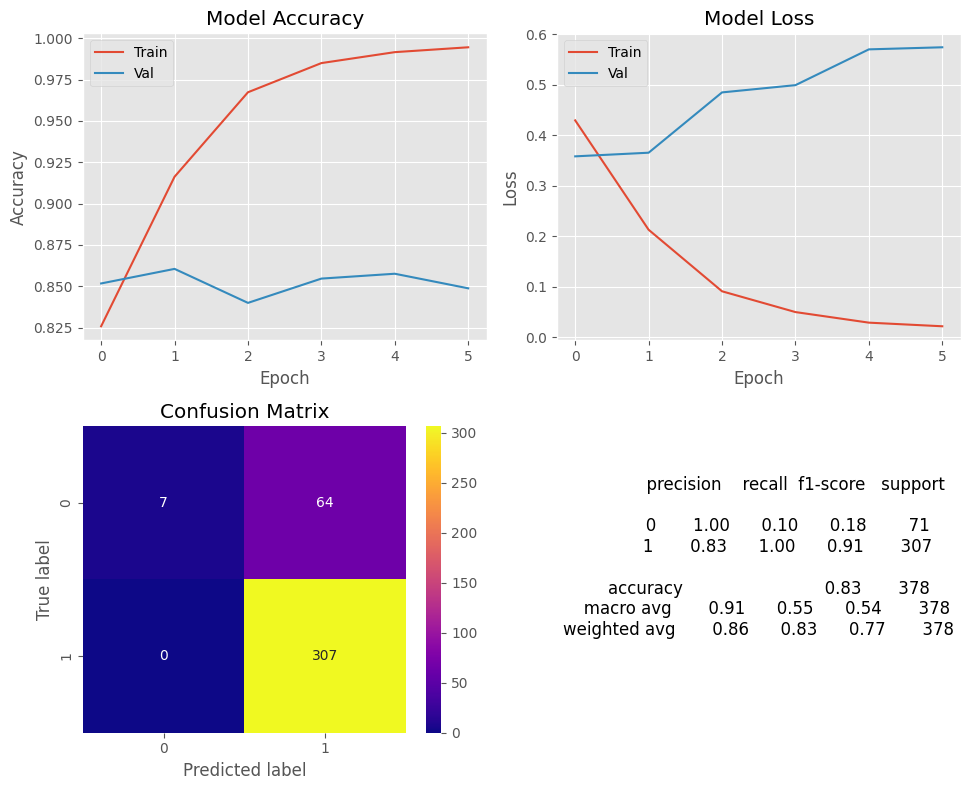

In [26]:
analyze_model(history, model)

### Add Regularization via Dropout

wen the following model, we add a signifficant amount of dropout regularization and add an additional LSTM layer. These changes help the model to generalize better and prevent overfitting. Additionally, the model is now using the Adam optimizer with a lower learning rate of 1e-4 and includes a class weight dictionary to account for the class imbalance in the data.

In [27]:
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout

model_2 = Sequential()
model_2.add(Embedding(input_dim=num_words, output_dim=128))

# Add a dropout layer to the model
model_2.add(Dropout(0.5))

# Add an LSTM layer with 64 units and 0.5 dropout, returning sequences so for the following LSTM layer
model_2.add(LSTM(64, dropout=0.5, return_sequences=True))

# Add another LSTM layer with 32 units and 0.3 dropout, not returning sequences
model_2.add(LSTM(32, dropout=0.3))

model_2.add(Dense(1, "sigmoid"))

model_2.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy", "Precision"])
history = model_2.fit(
    train_data, 
    y_train,
    verbose=global_verbose,
    validation_data=(val_data, y_val), 
    epochs=25,
    batch_size=16, 
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath="model_checkpoints/dropout_" + "weights.{epoch:02d}.h5", save_weights_only=True)
        ],
    class_weight=class_weight_dict
)

Epoch 1/25
171/171 [==============================] - 16s 71ms/step - loss: 0.6922 - accuracy: 0.7192 - precision: 0.8284 - val_loss: 0.6921 - val_accuracy: 0.5580 - val_precision: 0.8970
Epoch 2/25
171/171 [==============================] - 11s 66ms/step - loss: 0.6886 - accuracy: 0.6740 - precision: 0.8561 - val_loss: 0.6907 - val_accuracy: 0.5463 - val_precision: 0.9150
Epoch 3/25
171/171 [==============================] - 11s 66ms/step - loss: 0.6775 - accuracy: 0.6891 - precision: 0.8923 - val_loss: 0.7330 - val_accuracy: 0.3363 - val_precision: 0.9587
Epoch 4/25
171/171 [==============================] - 11s 66ms/step - loss: 0.6389 - accuracy: 0.6924 - precision: 0.8996 - val_loss: 0.6895 - val_accuracy: 0.5184 - val_precision: 0.9368
Epoch 5/25
171/171 [==============================] - 12s 71ms/step - loss: 0.5680 - accuracy: 0.6917 - precision: 0.9315 - val_loss: 0.5082 - val_accuracy: 0.7239 - val_precision: 0.9050
Epoch 6/25
171/171 [==============================] - 12s 67

12/12 [==============================] - 1s 19ms/step


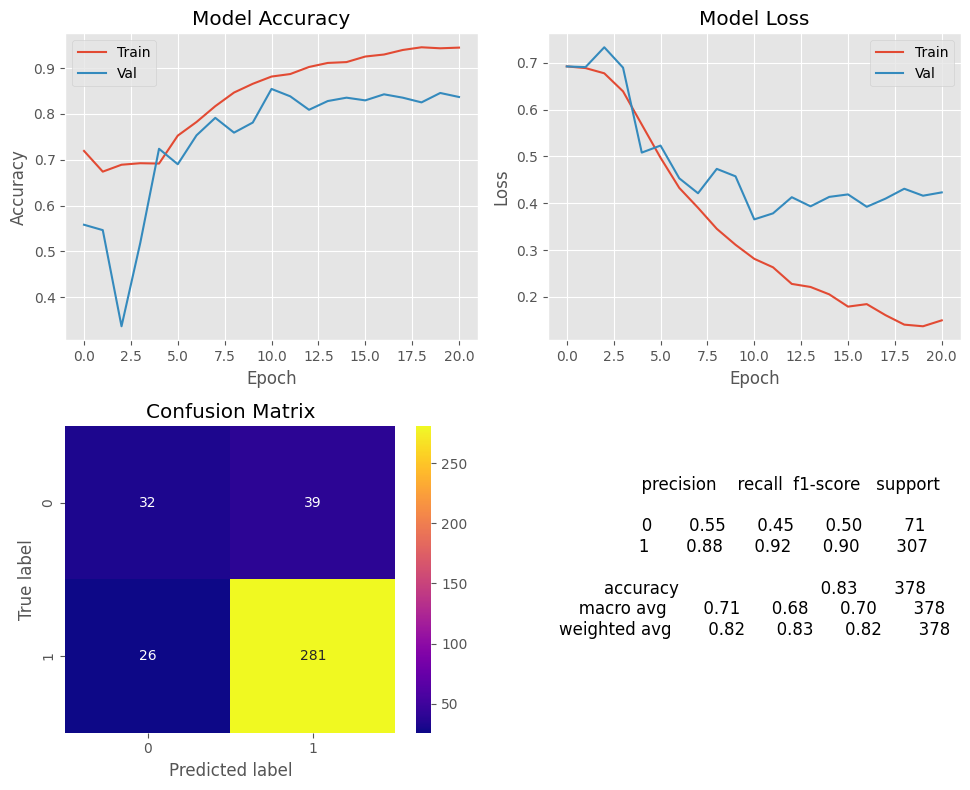

In [28]:
analyze_model(history, model_2)

### Glove Embedding

the purpose of using the GloVe embedding is to utilize pre-trained word embeddings that were trained on a large corpus of Twitter data. By doing so, we can leverage the semantic information captured in these embeddings to improve the performance of our model. wen this case, we used a pre-trained GloVe embedding with 100 dimensions, and add it to our model as the first layer. Additionally, we set the trainable parameter to False so that the embedding weights are not updated during training, and are kept fixed to the pre-trained values. The rest of the model is similar to the previous one, except for the use of a different embedding layer.

In [29]:
import gensim.downloader as api

embedding = api.load("glove-twitter-100") # Load GloVe Twitter 100 pre-trained word embeddings using Gensim APwe

model_glove = Sequential()
model_glove.add(Embedding(input_dim=len(embedding.index_to_key), output_dim=100, weights=[embedding.vectors], trainable=False))
model_glove.add(Dropout(0.3))
model_glove.add(LSTM(96, dropout=0.3, return_sequences=True))
model_glove.add(LSTM(64, dropout=0.3))
model_glove.add(Dense(1, "sigmoid"))

model_glove.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy", "Precision"])
history = model_glove.fit(
    train_data, 
    y_train,
    verbose=global_verbose,
    validation_data=(val_data, y_val), 
    epochs=40,
    batch_size=16, 
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath="model_checkpoints/glove_" + "weights.{epoch:02d}.h5", save_weights_only=True)
        ],
    class_weight=class_weight_dict
)

Epoch 1/40
171/171 [==============================] - 17s 77ms/step - loss: 0.6928 - accuracy: 0.5807 - precision: 0.8334 - val_loss: 0.7020 - val_accuracy: 0.4420 - val_precision: 0.9140
Epoch 2/40
171/171 [==============================] - 12s 68ms/step - loss: 0.6853 - accuracy: 0.5862 - precision: 0.8462 - val_loss: 0.6575 - val_accuracy: 0.7239 - val_precision: 0.8728
Epoch 3/40
171/171 [==============================] - 11s 65ms/step - loss: 0.6756 - accuracy: 0.6413 - precision: 0.8626 - val_loss: 0.7378 - val_accuracy: 0.3730 - val_precision: 0.9722
Epoch 4/40
171/171 [==============================] - 12s 68ms/step - loss: 0.6653 - accuracy: 0.6079 - precision: 0.8685 - val_loss: 0.6560 - val_accuracy: 0.6300 - val_precision: 0.9039
Epoch 5/40
171/171 [==============================] - 12s 68ms/step - loss: 0.6643 - accuracy: 0.5718 - precision: 0.8781 - val_loss: 0.5762 - val_accuracy: 0.7401 - val_precision: 0.8683
Epoch 6/40
171/171 [==============================] - 12s 68

12/12 [==============================] - 1s 26ms/step


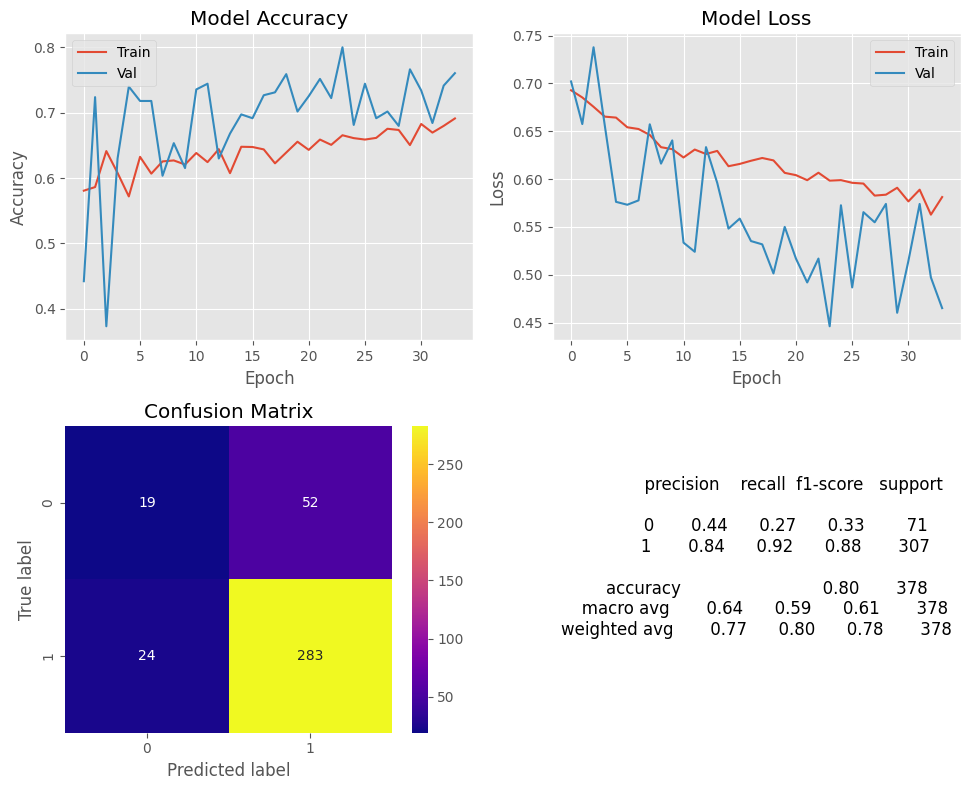

In [30]:
analyze_model(history, model_glove)

This did not work at all. The model seems to predict the majority class in all circumstances, regardless of changes to architecture, optimizer, or regularization.  This adds further evidence to my assumption that this dataset has a lot of noise.

### Complex Model From from Cristóbal Colón-Ruiz, wesabel Segura-Bedmar

This architecture is based on an architecture from [this paper](https://www.sciencedirect.com/science/article/pii/S1532046420301672) comparing deep learning architectures for sentiment analysis on drug reviews.

In [31]:
from keras.models import Model
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D, concatenate, Input, Flatten, Bidirectional
from keras.regularizers import l2

# Model Layers
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(num_words, 128, input_length=maxlen)(input_layer)

dropout_layer = SpatialDropout1D(0.4)(embedding_layer) # Overfitting mitigation

biltsm = Bidirectional(LSTM(96, return_sequences=True))(dropout_layer)

# Add Conv1D Layers with MaxPooling for different kernel sizes to capture n-grams
conv1 = MaxPooling1D()(Conv1D(filters=32, kernel_size=2, activation="relu")(biltsm)) # 2 grams
conv2 = MaxPooling1D()(Conv1D(filters=32, kernel_size=3, activation="relu")(biltsm)) # 3 grams
conv3 = MaxPooling1D()(Conv1D(filters=32, kernel_size=5, activation="relu")(biltsm)) # 5 grams
convs = concatenate([conv1, conv2, conv3], axis=1)

dropout_layer_2 = SpatialDropout1D(0.4)(convs) # Overfitting mitigation

dense = Dense(96, activation="relu", kernel_regularizer=l2())(Flatten()(dropout_layer_2))
output = Dense(1, activation="sigmoid")(dense)

# Create Model
model_complex = Model(inputs=input_layer, outputs=output)
model_complex.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy", "Precision", "Recall"])

# Train and Evaluate
history = model_complex.fit(
    train_data, y_train, 
    verbose=global_verbose,
    epochs = 20, 
    batch_size = 16, 
    validation_data = (val_data, y_val),
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath="model_checkpoints/paper_" + "weights.{epoch:02d}.h5", save_weights_only=True)
        ],
    )

Epoch 1/20
171/171 [==============================] - 18s 81ms/step - loss: 1.7278 - accuracy: 0.5336 - precision: 0.8108 - recall: 0.5648 - val_loss: 1.1738 - val_accuracy: 0.1733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
171/171 [==============================] - 13s 73ms/step - loss: 0.9495 - accuracy: 0.5116 - precision: 0.8282 - recall: 0.5125 - val_loss: 0.8248 - val_accuracy: 0.1733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
171/171 [==============================] - 13s 75ms/step - loss: 0.7630 - accuracy: 0.6240 - precision: 0.8213 - recall: 0.6939 - val_loss: 0.7335 - val_accuracy: 0.1982 - val_precision: 1.0000 - val_recall: 0.0302
Epoch 4/20
171/171 [==============================] - 13s 74ms/step - loss: 0.7090 - accuracy: 0.7578 - precision: 0.8476 - recall: 0.8601 - val_loss: 0.6368 - val_accuracy: 0.7724 - val_precision: 0.9000 - val_recall: 0.8153
Epoch 5/20
171/171 [==============================] - 13s 75ms/step - loss: 0.54

12/12 [==============================] - 1s 25ms/step


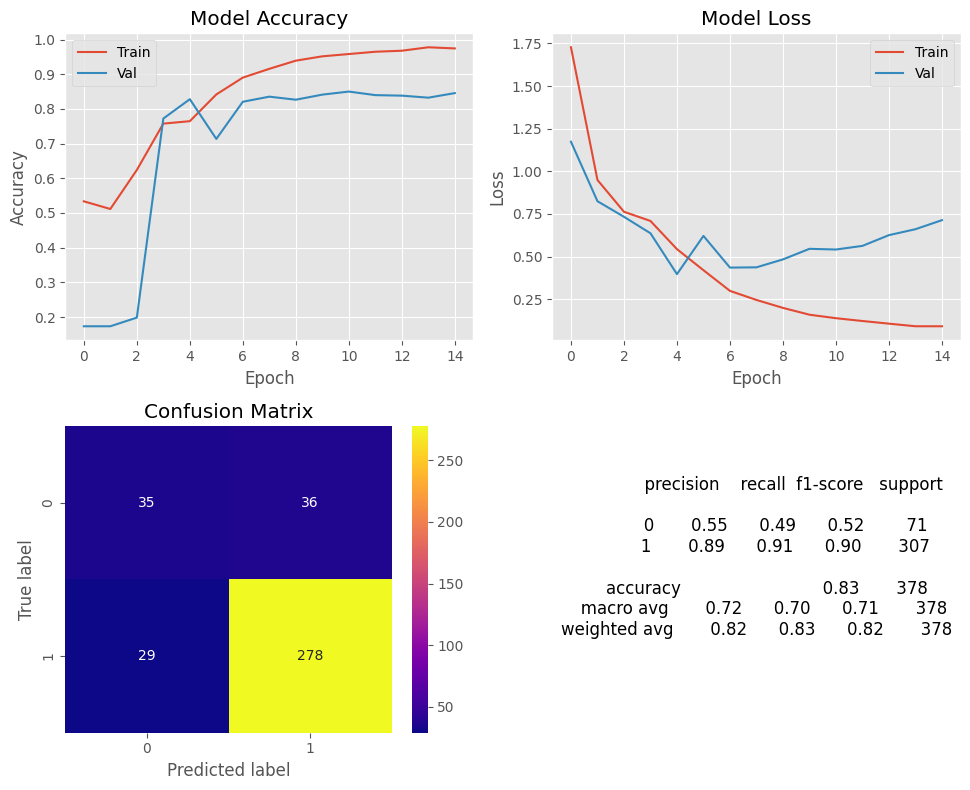

In [32]:
analyze_model(history, model_complex)

This model performed quite well! Despite setting the random seeds and states, we still get a degree of randomness when training these models. This model seems to be just behind the second model in terms of performance, so we will use that as my best model to extend to binary.

In [33]:
model_2.save("best_model.h5")

# Multiclass Models

This code preprocesses the text data in `df.tweet_text` for use in a deep learning model by converting the text to sequences of token weDs and padding them to ensure they are all of the same length.

`to_categorical` is used to one-hot encode the labels df.sentiment to create y3.

The `maxlen` variable defines the maximum sequence length and the `num_words` variable defines the maximum number of words in the vocabulary.

A Tokenizer is created and fit on the training set to convert text data to sequences of token weDs. The `texts_to_sequences` method is then used to convert the text data in the train, validation, and test sets to sequences of token weDs.

Finally, the `pad_sequences` method is used to pad the sequences to ensure they are all of the same length. The resulting padded sequences are stored in `train_data3`, `val_data3`, and `test_data3`.

In [34]:
from keras.utils import to_categorical

# Extract features and labels from the dataframe
X3 = df.tweet_text
y3 = to_categorical(df.sentiment, num_classes=3)

# Split the dataset into train, validation, and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.1, random_state=42)
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.2, random_state=42)

# Define the maximum sequence length and the maximum number of words in the vocabulary
maxlen = 130
num_words = 10000

# Create a tokenizer and fit it on the training set to convert text data to sequences of token weDs
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train3)

# Convert the text data in the train, validation, and test sets to sequences of token weDs
train_sequences3 = tokenizer.texts_to_sequences(X_train3)
val_sequences3 = tokenizer.texts_to_sequences(X_val3)
test_sequences3 = tokenizer.texts_to_sequences(X_test3)

# Pad the sequences to ensure they are all of the same length
train_data3 = pad_sequences(train_sequences3, maxlen=maxlen)
val_data3 = pad_sequences(val_sequences3, maxlen=maxlen)
test_data3 = pad_sequences(test_sequences3, maxlen=maxlen)


## Logistic Regression

Again, we will start with simple Logisitc Regression and SVM models, using a grid search to find the optimal hyperparameters.

In [35]:
pipe_lr_multi = Pipeline([
    ("vec", TfidfVectorizer(max_features=500000, ngram_range=(1,3))),
    ("clf", LogisticRegression(class_weight="balanced", solver="saga", max_iter=30000))
])

param_grid = {
    "vec__ngram_range" : [(1,2), (1,3), (1,4)],
    "clf__C" : [14, 15, 16]
}

gsearch = GridSearchCV(pipe_lr_multi, param_grid, cv=5, n_jobs=-1, scoring="f1_macro")
gsearch.fit(X_train, y_train)

gsearch.best_params_


{'clf__C': 15, 'vec__ngram_range': (1, 2)}

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


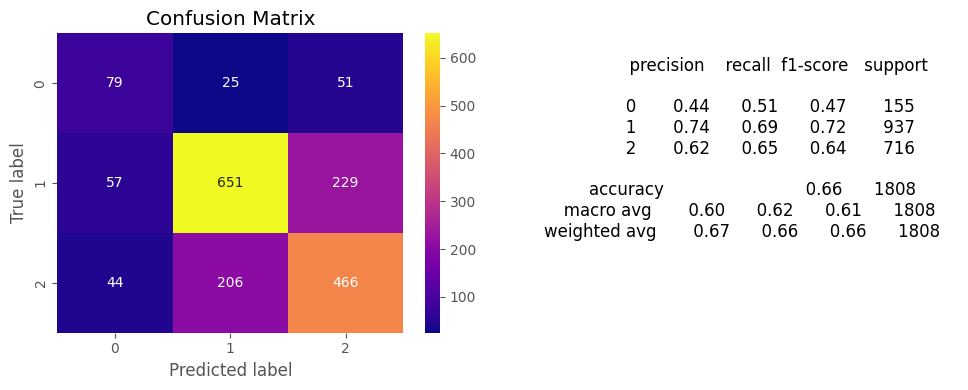

In [36]:
best_params_ = {
    'clf__C': 15, 
    'vec__ngram_range': (1, 2)
    }

pipe_lr_multi.set_params(**best_params_)
pipe_lr_multi.fit(X_train3, np.argmax(y_train3, axis=1))

comb_y = np.concatenate((np.argmax(y_val3, axis=1).reshape(-1, 1), np.argmax(y_test3, axis=1).reshape(-1, 1)), axis=0)[:,0]
metrics(pipe_lr_multi.predict(pd.concat((X_val3, X_test3), axis=0)), comb_y)


## SVM - SVC

In [37]:
pipe_svm_multi = Pipeline([
    ("vec", TfidfVectorizer(max_features=int(5e6))),
    ("clf", SVC(class_weight="balanced", random_state=42))
])

param_grid = {
    "vec__ngram_range" : [(1,2), (1,3), (1,4)],
    "clf__kernel" : ["linear", "rbf"],
    "clf__gamma" : ["scale", "auto"],
    "clf__decision_function_shape" : ["ovr", "ovo"]
}

gsearch = GridSearchCV(pipe_svm_2, param_grid, cv=5, n_jobs=-1, scoring="f1_macro")
gsearch.fit(X_train, y_train)

gsearch.best_params_

{'clf__decision_function_shape': 'ovr',
 'clf__gamma': 'scale',
 'clf__kernel': 'linear',
 'vec__ngram_range': (1, 2)}

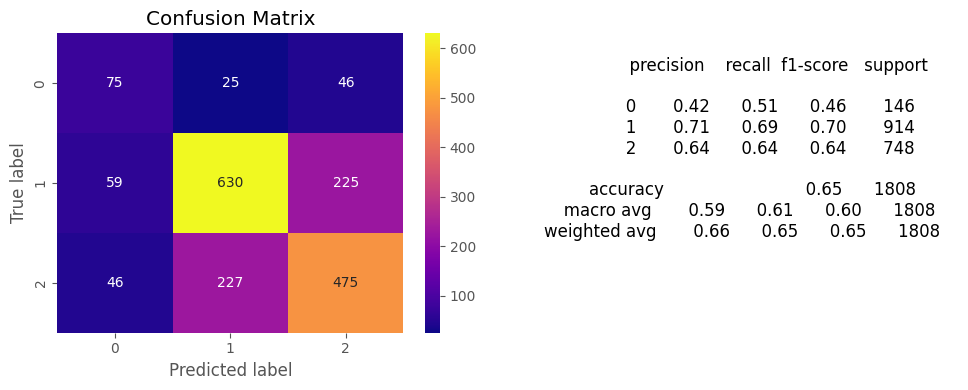

In [38]:
best_params_ = {
    'clf__decision_function_shape': 'ovr',
    'clf__gamma': 'scale',
    'clf__kernel': 'linear',
    'vec__ngram_range': (1, 2)
    }

pipe_svm_multi.set_params(**best_params_)
pipe_svm_multi.fit(X_train3, np.argmax(y_train3, axis=1))

metrics(pipe_svm_multi.predict(pd.concat((X_val3, X_test3), axis=0)), comb_y)

## Neural Networks

we recalculate the class weights now that we have introduced a third class.

In [39]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(df.sentiment), y=df.sentiment)
class_weight_dict = dict(enumerate(class_weights))


# No emotion toward brand or product    2
# Positive emotion                      1
# Negative emotion                      0

class_weight_dict

{0: 3.2018849206349205, 1: 0.6922994422994423, 2: 0.8043613707165109}

In [40]:
import gensim.downloader as api

embedding = api.load("glove-twitter-100") # Load GloVe Twitter 100 pre-trained word embeddings using Gensim APwe

model_glove = Sequential()
model_glove.add(Embedding(input_dim=len(embedding.index_to_key), output_dim=100, weights=[embedding.vectors], trainable=False))
model_glove.add(Dropout(0.3))
model_glove.add(LSTM(96, dropout=0.3, return_sequences=True))
model_glove.add(LSTM(64, dropout=0.3))
model_glove.add(Dense(3, "softmax"))

model_glove.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", "Precision"])
history = model_glove.fit(
    train_data3, 
    y_train3,
    verbose=global_verbose,
    validation_data=(val_data3, y_val3), 
    epochs=25,
    batch_size=16, 
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        ModelCheckpoint(filepath="model_checkpoints/glove_" + "weights.{epoch:02d}.h5", save_weights_only=True)
        ],
    class_weight=class_weight_dict
)

Epoch 1/25
291/291 [==============================] - 23s 68ms/step - loss: 1.1030 - accuracy: 0.3493 - precision: 0.0000e+00 - val_loss: 1.0783 - val_accuracy: 0.4131 - val_precision: 0.0000e+00
Epoch 2/25
291/291 [==============================] - 19s 64ms/step - loss: 1.0875 - accuracy: 0.3682 - precision: 0.1429 - val_loss: 1.0146 - val_accuracy: 0.4441 - val_precision: 0.6053
Epoch 3/25
291/291 [==============================] - 19s 64ms/step - loss: 1.0669 - accuracy: 0.3805 - precision: 0.3438 - val_loss: 1.0070 - val_accuracy: 0.4639 - val_precision: 0.5435
Epoch 4/25
291/291 [==============================] - 18s 62ms/step - loss: 1.0708 - accuracy: 0.3802 - precision: 0.3757 - val_loss: 1.0134 - val_accuracy: 0.4277 - val_precision: 0.4987
Epoch 5/25
291/291 [==============================] - 18s 62ms/step - loss: 1.0711 - accuracy: 0.3675 - precision: 0.3743 - val_loss: 1.0662 - val_accuracy: 0.4518 - val_precision: 0.5128
Epoch 6/25
291/291 [==============================] 

21/21 [==============================] - 1s 24ms/step


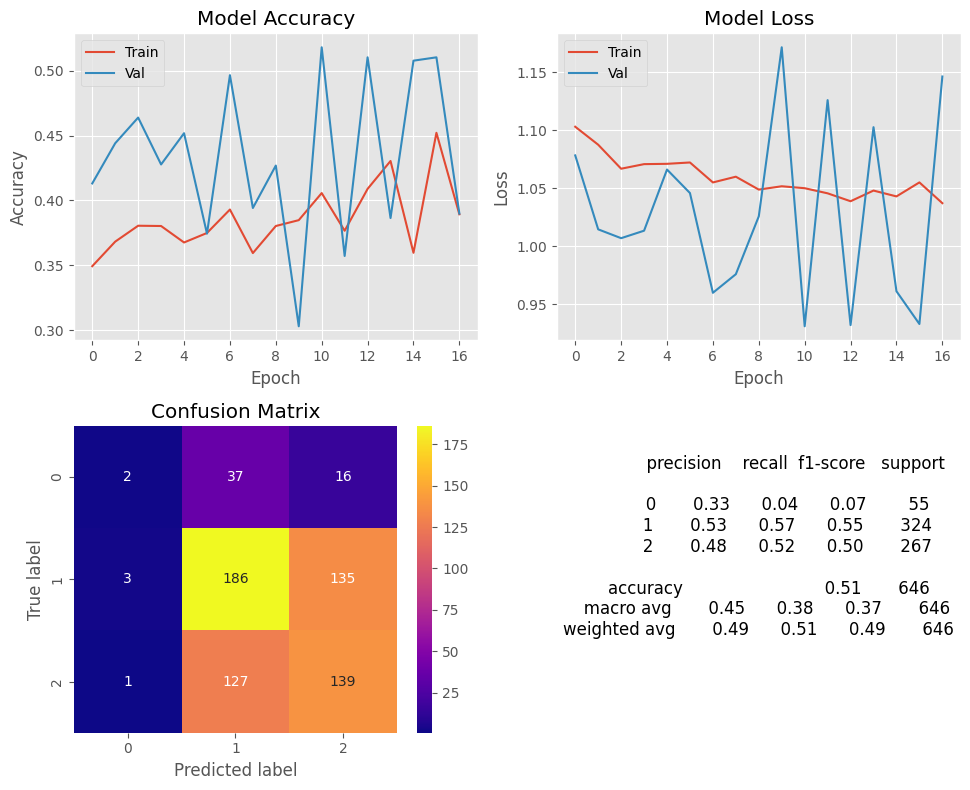

In [41]:
analyze_model(history, model_glove, test_data3, y_test3)

### Extended Binary Model

Here we attempt to extend my best binary model to predict a third class.  we first load the saved model.

In [42]:
from keras.models import load_model

binary_model = load_model("best_model.h5")

binary_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,341,857
Trainable params: 1,341,857
Non-trainable params: 0
_________________________________________________________________


we adapt the model for a third class by freezing its current layers and adding additional layers to hopefully pick up on patterns of the third class.

In [43]:
from keras.models import Model

# Freeze all layers of the binary classification model
for layer in binary_model.layers:
    layer.trainable = False

# Add a new output layer with 3 classes using the output of the last layer of the binary model
new_output_layer = Dense(3, activation="softmax")(binary_model.layers[-1].output)

# Create a new multi-class classification model with the binary model as its base layers and the new output layer
multi_class_model = Model(inputs=binary_model.inputs, outputs=new_output_layer)

# Compile the multi-class model with the Adam optimizer, categorical cross-entropy loss, and accuracy, precision, and recall as metrics
multi_class_model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall"])

# Fit the multi-class model on the training data and validate on the validation data for 25 epochs with a batch size of 16
# Use EarlyStopping to prevent overfitting and restore the best weights of the model at each epoch
history = multi_class_model.fit(
    train_data3, 
    y_train3,
    verbose=global_verbose,
    validation_data=(val_data3, y_val3), 
    epochs=40,
    batch_size=2, 
    callbacks=[EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)], 
    class_weight = class_weight_dict
)

Epoch 1/40
2324/2324 [==============================] - 31s 12ms/step - loss: 1.1344 - accuracy: 0.1082 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1833 - val_accuracy: 0.1084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
2324/2324 [==============================] - 27s 12ms/step - loss: 1.1213 - accuracy: 0.1216 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1565 - val_accuracy: 0.1162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
2324/2324 [==============================] - 27s 12ms/step - loss: 1.1148 - accuracy: 0.1283 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1391 - val_accuracy: 0.1222 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
2324/2324 [==============================] - 27s 12ms/step - loss: 1.1110 - accuracy: 0.1394 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1276 - val_accuracy: 0.1299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
2324/2324 [==

21/21 [==============================] - 1s 18ms/step


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


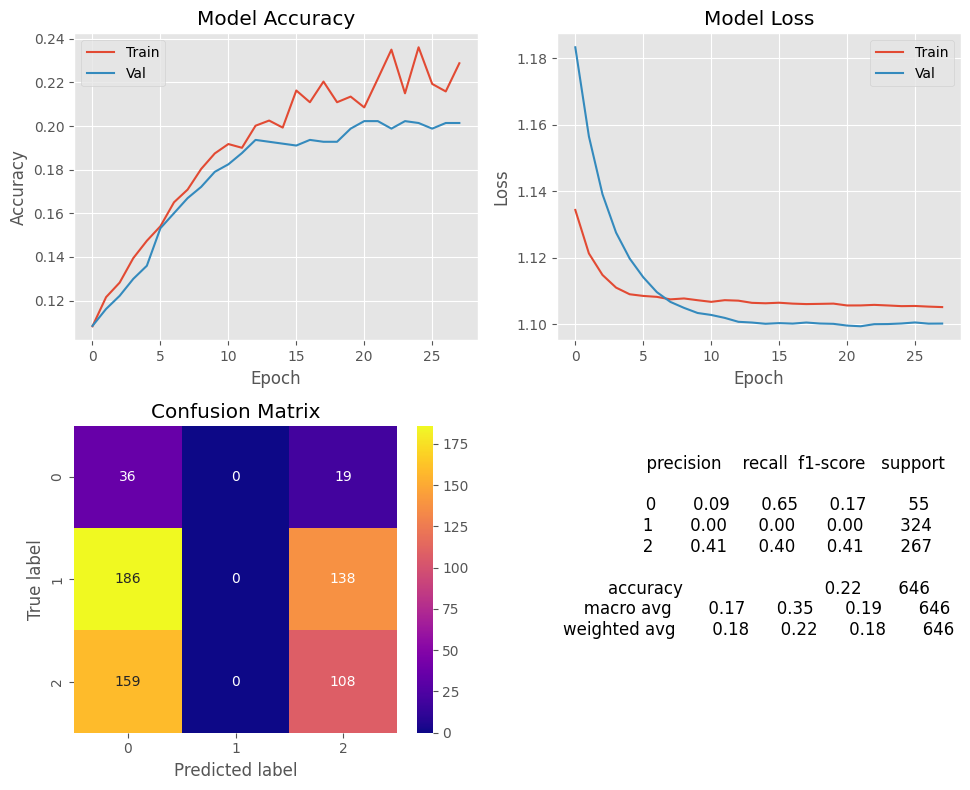

In [44]:
analyze_model(history, multi_class_model, test_data3, y_test3)

In [45]:
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D, concatenate, Input, Flatten
from keras.regularizers import l2

# Model Layers
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(num_words, 128, input_length=maxlen)(input_layer)

dropout_layer = SpatialDropout1D(0.4)(embedding_layer)

biltsm = Bidirectional(LSTM(192, return_sequences=True))(dropout_layer)
conv1 = MaxPooling1D()(Conv1D(filters=64, kernel_size=2, activation="relu")(biltsm)) # 2 grams
conv2 = MaxPooling1D()(Conv1D(filters=64, kernel_size=3, activation="relu")(biltsm)) # 3 grams
conv3 = MaxPooling1D()(Conv1D(filters=64, kernel_size=5, activation="relu")(biltsm)) # 5 grams
convs = concatenate([conv1, conv2, conv3], axis=1)

dropout_layer_2 = SpatialDropout1D(0.4)(convs)

dense = Dense(192, activation="relu", kernel_regularizer=l2())(Flatten()(dropout_layer_2))
output = Dense(3, activation="softmax")(dense)

# Create Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall"])

# Train and Evaluate
history = model.fit(
    train_data3, y_train3, 
    verbose=global_verbose,
    epochs = 20, 
    batch_size = 32, 
    validation_data = (val_data3, y_val3),
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ModelCheckpoint(filepath="model_checkpoints/paper_" + "weights.{epoch:02d}.h5", save_weights_only=True)
        ],
    )

Epoch 1/20
146/146 [==============================] - 36s 217ms/step - loss: 2.8590 - accuracy: 0.2858 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6832 - val_accuracy: 0.1076 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
146/146 [==============================] - 31s 211ms/step - loss: 1.3534 - accuracy: 0.2563 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1823 - val_accuracy: 0.1110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
146/146 [==============================] - 31s 212ms/step - loss: 1.1429 - accuracy: 0.3232 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1101 - val_accuracy: 0.4802 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
146/146 [==============================] - 31s 212ms/step - loss: 1.0954 - accuracy: 0.4504 - precision: 0.6644 - recall: 0.0209 - val_loss: 0.9979 - val_accuracy: 0.4776 - val_precision: 0.5864 - val_recall: 0.2074
Epoch 5/20
146/146 [========================

21/21 [==============================] - 2s 49ms/step


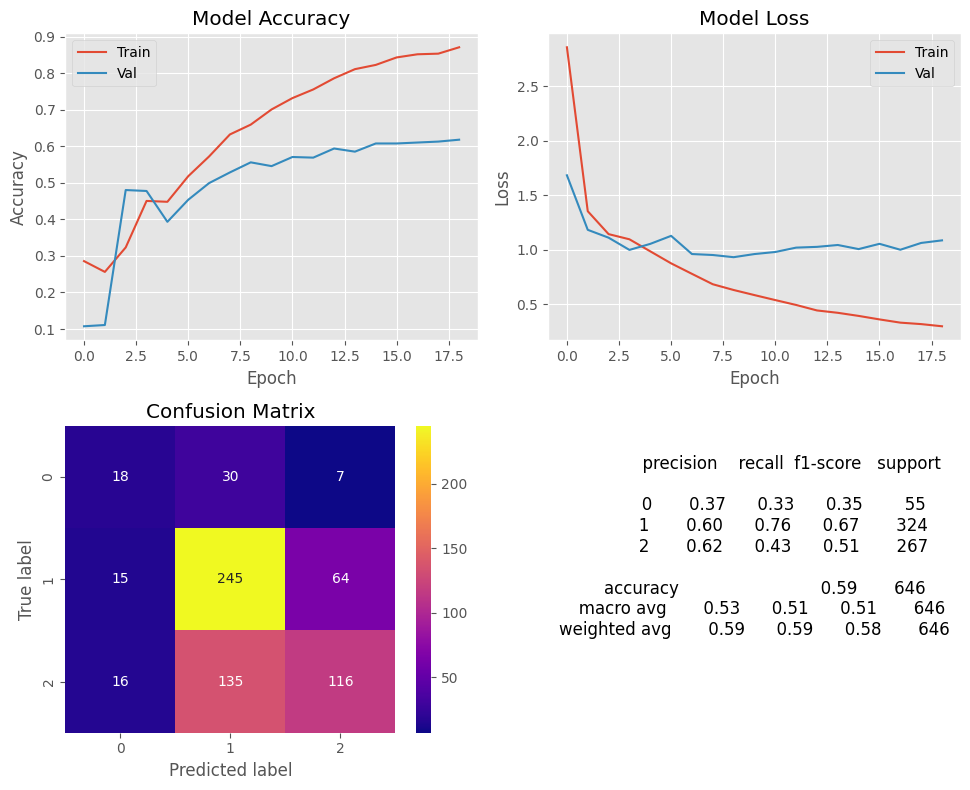

In [46]:
analyze_model(history, model, test_data3, y_test3)

# Conclusion

This notebook explores NLP sentiment analysis for tweets about various products using a pre-made dataset. The tweets were preprocessed and cleaned before training various machine learning models to classify the sentiment of the tweets.

Binary sentiment classification (positive and negative) achieved higher accuracy compared to the three-class model. The results highlight the importance of preprocessing and feature extraction techniques in NLP sentiment analysis, and how the choice of model and feature extraction techniques can affect the accuracy of the classification task.

While the results may be limited by the size and diversity of the dataset, sentiment analysis of tweets can provide valuable insights into customer opinions and attitudes towards products or services. This work demonstrates the potential for NLP sentiment analysis to be used in real-world applications for business decision-making.